Thinkful Capstone Project #1 - "Analyzing Speed Camera Violations Across Chicago"
by Ilango Gopalan, August 2019


In 2013, the city of Chicago announced that 50 'zones' around parks and schools would be equipped 
with automated speed enforcement cameras.  These cameras are part of the Children's Safety Zone Program, and were
installed with the expectation of having motorists reduce speeding near the zones.


The dataset for this project is found here: 
https://data.cityofchicago.org/Transportation/Speed-Camera-Violations/hhkd-xvj4

This dataset reflects the daily volume of violations that have occurred in Children's Safety Zones for each camera. 
The data reflects violations that occurred from July 1, 2014 until present, minus the most recent 14 days.
As of July 2019, there are 163 speed cameras in Chicago, across 50 wards, and 77 community areas

A children's safety zone is designated as a 1/8th of a mile boundary around any Chicago parks or schools. 
The program uses enhanced signage and automated safety cameras to identify and ticket motorists who exceeded speed limits.

Chicago is made up of 77 community areas that are often grouped into 9 districts or “sides.” 
The community areas are well defined and do not overlap. 
Each community area has one or more neighborhoods in it. The neighborhoods are often not well defined and over lap each other.

From this report, a reader will be able to answer the following questions:
1. Have the overall speeding violations increased or decreased year over year?
2. How does the speeding violation volume depend on the season? 
3. Which wards, addresses, and community areas have the most violations?

Additionally, the report will show areas for future further analysis.  

In [1]:
%pylab inline
#%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import calendar
import datetime
from scipy.stats import ttest_ind

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
#The csv file contains ~195,000 rows from 7/1/2014 to 7/23/2019
df = pd.read_csv('Thinkful_Chicago_Speed_Camera_Violations.csv') 
df.head()  #default is 5 rows returned

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,7122 S SOUTH CHICAGO AVE,CHI184,7/23/2019,196,1182950.681,1857907.892,41.765301,-87.604985,"(41.76530133793055, -87.60498537037378)",32.0,21546.0,67.0,121.0,33.0
1,445 W 127TH,CHI045,7/23/2019,102,1175468.446,1820629.229,41.663174,-87.633520,"(41.663174059325534, -87.63352045241697)",30.0,21861.0,50.0,7.0,43.0
2,536 E MORGAN DR,CHI029,7/23/2019,100,1180984.657,1868164.766,41.793493,-87.611876,"(41.793492645896656, -87.6118759701359)",53.0,22260.0,7.0,401.0,4.0
3,4909 N CICERO AVE,CHI149,7/23/2019,69,1143500.842,1932251.247,41.970135,-87.747724,"(41.970134735816295, -87.7477237971432)",28.0,21869.0,14.0,751.0,38.0
4,8020 W FOREST PRESERVE AV,CHI174,7/23/2019,68,1121895.053,1922705.872,41.944319,-87.827378,"(41.944318833069445, -87.8273782786742)",39.0,22254.0,17.0,413.0,19.0


In [3]:
df_clean = df.drop(columns = ['X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Historical Wards 2003-2015', 'Census Tracts'])  
#For this report I am focusing on speeding violation volume across areas, wards, seasons, and years.  
#Therefore, I removed all columns pertaining to the camera ID and its location.  But I kept the address and camera ID
df_clean.head()

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,Zip Codes,Community Areas,Wards
0,7122 S SOUTH CHICAGO AVE,CHI184,7/23/2019,196,21546.0,67.0,33.0
1,445 W 127TH,CHI045,7/23/2019,102,21861.0,50.0,43.0
2,536 E MORGAN DR,CHI029,7/23/2019,100,22260.0,7.0,4.0
3,4909 N CICERO AVE,CHI149,7/23/2019,69,21869.0,14.0,38.0
4,8020 W FOREST PRESERVE AV,CHI174,7/23/2019,68,22254.0,17.0,19.0


In [4]:
#I chose to separate out the 'VIOLATION DATE', so I could use the month and year for analysis
date_split = df['VIOLATION DATE'].str.split('/', expand = True) 
violation_month = date_split[0].astype(int)
violation_day = date_split[1].astype(int)
violation_year = date_split[2].astype(int)
#Now I want to add that violation month column into the dataframe
df_clean['violation_month'] = violation_month

In [ ]:
df_clean['violation_year'] = violation_year #I added this column to show trends year over year
df_clean.head()

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,Zip Codes,Community Areas,Wards,violation_month,violation_year
0,7122 S SOUTH CHICAGO AVE,CHI184,7/23/2019,196,21546.0,67.0,33.0,7,2019
1,445 W 127TH,CHI045,7/23/2019,102,21861.0,50.0,43.0,7,2019
2,536 E MORGAN DR,CHI029,7/23/2019,100,22260.0,7.0,4.0,7,2019
3,4909 N CICERO AVE,CHI149,7/23/2019,69,21869.0,14.0,38.0,7,2019
4,8020 W FOREST PRESERVE AV,CHI174,7/23/2019,68,22254.0,17.0,19.0,7,2019


In [ ]:
#Once I created a 'violation_month' column, I converted the months into one of four seasons
def return_season(x):
    x = int(x)
    if x == 6 or x == 7 or x == 8:
        return "Summer"
    elif x == 9 or x== 10 or x ==11:
        return "Fall"
    elif x == 12 or x == 1 or x == 2:
        return "Winter"
    elif x == 3 or x == 4 or x == 5:
        return "Spring"
    
df_clean['violation_season'] = df_clean['violation_month'].apply(return_season)

In [ ]:
df_clean.head() #I continuosly run the data frame to ensure I have the right material.


,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,Zip Codes,Community Areas,Wards,violation_month,violation_year,violation_season
0,7122 S SOUTH CHICAGO AVE,CHI184,7/23/2019,196,21546.0,67.0,33.0,7,2019,Summer
1,445 W 127TH,CHI045,7/23/2019,102,21861.0,50.0,43.0,7,2019,Summer
2,536 E MORGAN DR,CHI029,7/23/2019,100,22260.0,7.0,4.0,7,2019,Summer
3,4909 N CICERO AVE,CHI149,7/23/2019,69,21869.0,14.0,38.0,7,2019,Summer
4,8020 W FOREST PRESERVE AV,CHI174,7/23/2019,68,22254.0,17.0,19.0,7,2019,Summer


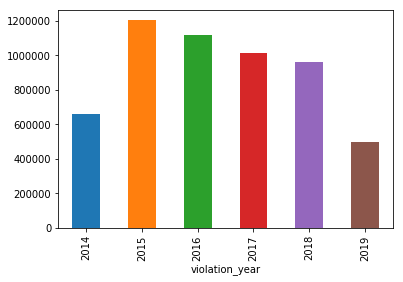

In [ ]:
#My first graph compares total speeding violations per year
df_clean.groupby(['violation_year'])['VIOLATIONS'].sum().plot.bar() 
#It is clear that speeding violations dropped over the years, after an initial spike from 2014-2015

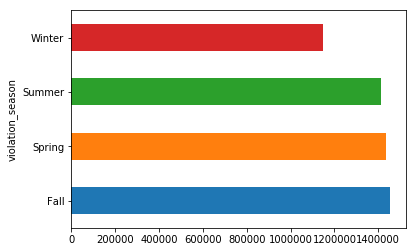

In [ ]:
#Next, I wanted to see what impact a season would have on speeding violations
df_clean.groupby(['violation_season'])['VIOLATIONS'].sum().plot.barh()
#An assumption could be made that fewer vehicles are on the road in the winter, hence the decrease in violations.
#Another assumption is that the vehicle volume may be similar, but that drivers exercise more caution on icy/snowy roads.

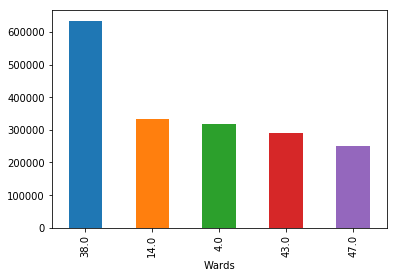

In [ ]:
#These next few bar charts will provide detail as to where the most speeding violations occurred by ward, community area, and address.
#Due to the very high volume of data points, I chose to show the 5 largest wards, community areas, and addresses.


df_clean_top5wards = df_clean.groupby(['Wards'])['VIOLATIONS'].sum().nlargest()
df_clean_top5wards.plot.bar()

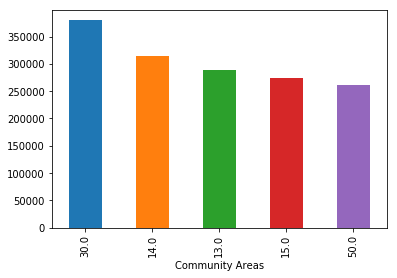

In [ ]:
df_clean_top5comm_areas = df_clean.groupby(['Community Areas'])['VIOLATIONS'].sum().nlargest()
df_clean_top5comm_areas.plot.bar()

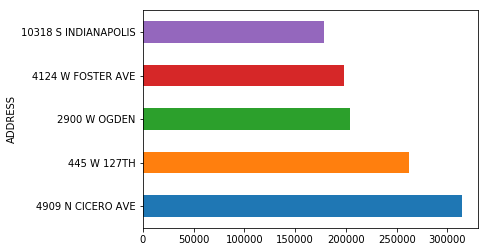

In [ ]:
df_clean_top5address = df_clean.groupby(['ADDRESS'])['VIOLATIONS'].sum().nlargest()
df_clean_top5address.plot.barh()

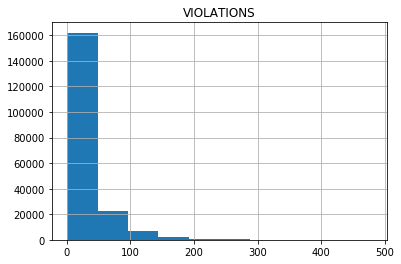

In [ ]:
#The histogram does not appear normally distributed, but is skewed right
df_hist = df_clean.hist(column = 'VIOLATIONS', bins = 10)
plt.show()

Further analysis and future research would be done to answer the following questions:

*How would a heat map of Chicago appear by community area and ward based on the number of speeding violations?

*How do the property values by ward correspond to areas with the highest volume of speeding violations, and which alderman may face scrutiny based on a high number of violations (residents upset with speeding tickets), or based on a low number of cameras (suggesting that more accidents are occuring)?

*How has overall accident volume been impacted by camera placement, and what are the dates for camera implementation?